# Классификация знаков Дорожного Движения

In [3]:
# !pip install natsort

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, initializers
from skimage import transform

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')


import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import cv2
import os

from imutils import paths
import os
import pathlib
import LRFinder
from natsort import natsorted

Tensorflow version 2.10.0
GPU is ON


In [5]:
data = []
labels = []
sumu =0
start = 0
input_size = (60,90)
path = "./New_Dataset/add_information_signs/"
num_classes = len(os.listdir(path))
for file_number in os.listdir(path):
    path2 = str("./New_Dataset/add_information_signs/"+file_number)
    num = 0
    count=0
    for file_number_2 in os.listdir(path2):
        path3 = str(path2 + '/' + file_number_2)
#         if count == 550: break
        count = count+1
        imagepath = (path3)
#         print(imagepath)
        image = cv2.imread(imagepath, 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image = transform.resize(image, input_size)
        data.append(image)

        label = file_number
        labels.append(label)
    num = num + count
    sumu = sumu+count
    print(label, num)
print('all',sumu)

183 857
184 1325
185 1145
186 677
187 353
188 209
189 353
190 1397
191 173
192 317
193 173
194 173
195 173
196 173
197 857
198 173
199 281
200 173
201 209
202 173
203 317
204 389
all 10070


In [6]:
df = pd.DataFrame({'labels': labels})
print(df.nunique())
print(df['labels'].value_counts())

labels    22
dtype: int64
190    1397
184    1325
185    1145
183     857
197     857
186     677
204     389
189     353
187     353
192     317
203     317
199     281
188     209
201     209
191     173
193     173
195     173
196     173
198     173
200     173
202     173
194     173
Name: labels, dtype: int64


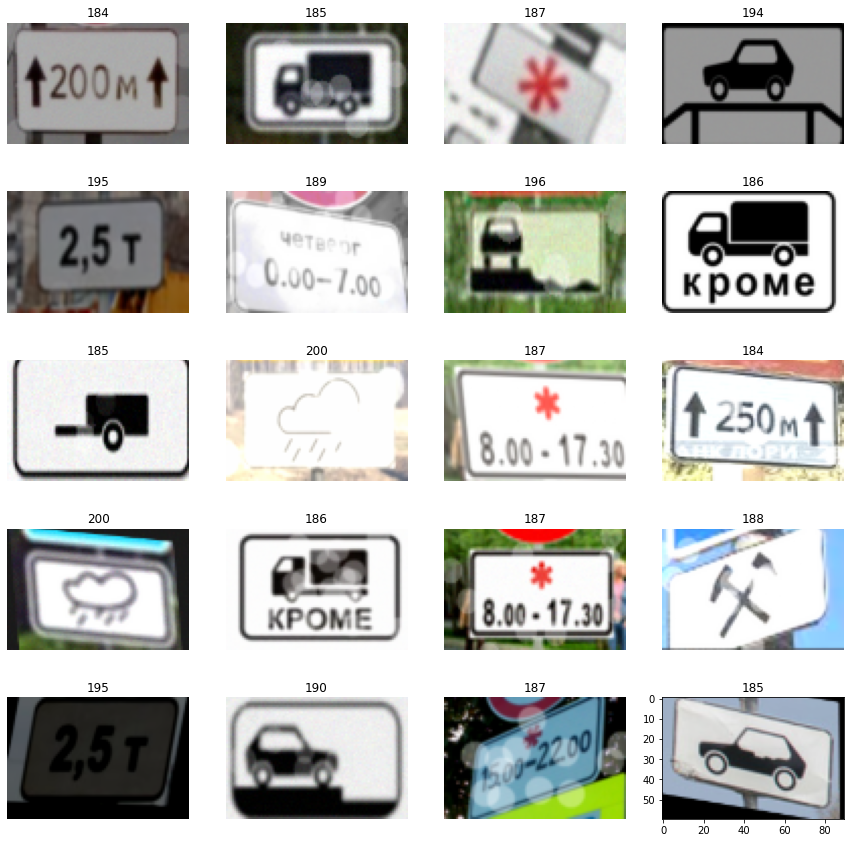

In [7]:
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    z = random.randint(1,len(labels))
    plt.axis('off') 
    fig.add_subplot(rows, columns, i)
    plt.title(labels[z])
    plt.imshow(data[z])
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 42, test_size = 0.3, stratify = labels)

from keras.utils import to_categorical
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [9]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D,UpSampling2D,ZeroPadding2D, Dense, Flatten, Dropout, BatchNormalization , Input, ReLU
from keras import initializers
import math
import tensorflow_addons as tfa

from keras.optimizers import SGD, Adam

opt = SGD(learning_rate=0.008)
# opt = Adam(learning_rate=0.0001)
# opt = SGD()
initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)

model = Sequential()
model.add(Input(shape=np.array(X_train).shape[1:]))

# model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=32, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.05))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=64, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.1))

# model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=128, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.15))

# model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(filters=256, kernel_size=5, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.2))

model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))


model.add(Flatten()) # по кол-ву пикселей из 2д в 1д
model.add(Dense(128, activation='swish')) # кол-во нейронов в слое
model.add(Dense(64, activation='swish')) # кол-во нейронов в слое
model.add(Dense(32, activation='swish')) # кол-во нейронов в слое
model.add(Dense(num_classes, kernel_initializer=initializer, bias_initializer=initializer, activation='softmax'))  # кол-во нейронов на выходе, по кол-ву классов


model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 88, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 44, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 29, 44, 32)        0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 31, 46, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 44, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 22, 64)       0

In [10]:
# lr_finder = LRFinder.LRFinder(model)
# lr_finder.find(np.array(X_train), np.array(y_train), start_lr=0.00001, end_lr=0.001, batch_size=10, epochs=20)
# lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [11]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=10, epochs=50, validation_data=(np.array(X_test), np.array(y_test)))

Epoch 1/50
705/705 [==============================] - 22s 25ms/step - loss: 2.4127 - f1_score: 0.0956 - val_loss: 1.7613 - val_f1_score: 0.1678
Epoch 2/50
705/705 [==============================] - 18s 25ms/step - loss: 1.3611 - f1_score: 0.3203 - val_loss: 1.2262 - val_f1_score: 0.4009
Epoch 3/50
705/705 [==============================] - 17s 24ms/step - loss: 0.6979 - f1_score: 0.6920 - val_loss: 0.4700 - val_f1_score: 0.8030
Epoch 4/50
705/705 [==============================] - 17s 25ms/step - loss: 0.3600 - f1_score: 0.8592 - val_loss: 0.2341 - val_f1_score: 0.9209
Epoch 5/50
705/705 [==============================] - 17s 24ms/step - loss: 0.2273 - f1_score: 0.9151 - val_loss: 0.2476 - val_f1_score: 0.9002
Epoch 6/50
705/705 [==============================] - 17s 24ms/step - loss: 0.1415 - f1_score: 0.9490 - val_loss: 0.1596 - val_f1_score: 0.9517
Epoch 7/50
705/705 [==============================] - 17s 24ms/step - loss: 0.1051 - f1_score: 0.9666 - val_loss: 0.1234 - val_f1_score:

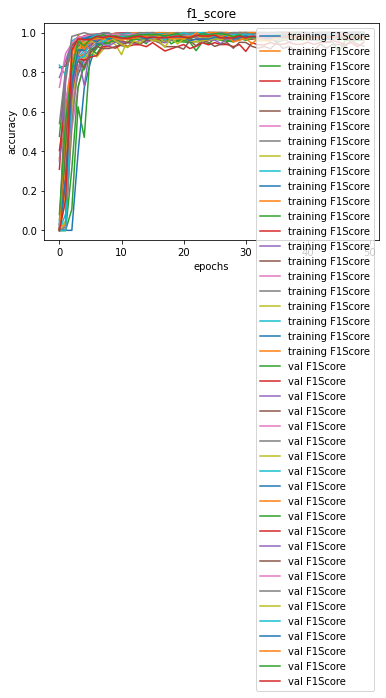

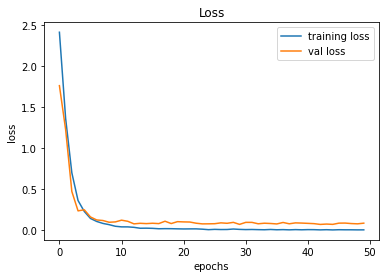

In [12]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['f1_score'], label='training F1Score')
plt.plot(history.history['val_f1_score'], label='val F1Score')
plt.title('f1_score')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [19]:
# model.save('./saved_models/Trafic_Signs_CNN_add_signs.h5')

In [14]:
add_signs_classes = {'0':183,
                     '1':184,
                     '2':185,
                     '3':186,
                     '4':187,
                     '5':188,
                     '6':189,
                     '7':190,
                     '8':191,
                     '9':192,
                     '10':193,
                     '11':194,
                     '12':195,
                     '13':196,
                     '14':197,
                     '15':198,
                     '16':199,
                     '17':200,
                     '18':201,
                     '19':202,
                     '20':203,
                     '21':204}

In [15]:
# len(df.loc[df['ClassId'] == c])

In [16]:
from sklearn.metrics import f1_score
df = pd.read_csv('./Data_images/Test_data.csv')
all_classes = []
predicted_classes = []

for c in range (183,205):
    for i in range(100):
        
        all_classes.append(c)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
        classid = df.loc[df['ClassId'] == c].values[i][0]
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(add_signs_classes[str(prediction[0])])
        
        if classid != add_signs_classes[(str(prediction[0]))]:
             print(classid,add_signs_classes[(str(prediction[0]))], prediction[0], image_path)


1/1 [==============================] - 0s 17ms/step
183 190 7 Test/183_3_16.png
1/1 [==============================] - 0s 16ms/step
183 193 10 Test/183_6_29.png
1/1 [==============================] - 0s 16ms/step
183 187 4 Test/183_7_27.png
1/1 [==============================] - 0s 17ms/step
183 187 4 Test/183_3_36.png
1/1 [==============================] - 0s 16ms/step
183 195 12 Test/183_6_19.png
1/1 [==============================] - 0s 16ms/step
184 189 6 Test/184_1_10.png
1/1 [==============================] - 0s 17ms/step
184 187 4 Test/184_2_22.png
1/1 [==============================] - 0s 21ms/step
184 183 0 Test/184_6_19.png
1/1 [==============================] - 0s 16ms/step
184 187 4 Test/184_1_25.png
1/1 [==============================] - 0s 23ms/step
184 189 6 Test/184_7_30.png
1/1 [==============================] - 0s 17ms/step
184 187 4 Test/184_7_8.png
1/1 [==============================] - 0s 17ms/step
184 183 0 Test/184_6_25.png
1/1 [==============================] - 

1/1 [==============================] - 0s 16ms/step
186 185 2 Test/186_3_27.png
1/1 [==============================] - 0s 16ms/step
187 189 6 Test/187_2_14.png
1/1 [==============================] - 0s 19ms/step
187 191 8 Test/187_4_17.png
1/1 [==============================] - 0s 16ms/step
187 183 0 Test/187_2_22.png
1/1 [==============================] - 0s 16ms/step
187 190 7 Test/187_5_20.png
1/1 [==============================] - 0s 16ms/step
187 189 6 Test/187_6_8.png
1/1 [==============================] - 0s 16ms/step
187 189 6 Test/187_5_17.png
1/1 [==============================] - 0s 16ms/step
188 187 4 Test/188_1_28.png
1/1 [==============================] - 0s 16ms/step
188 195 12 Test/188_5_4.png
1/1 [==============================] - 0s 17ms/step
188 200 17 Test/188_4_18.png
1/1 [==============================] - 0s 17ms/step
188 196 13 Test/188_3_22.png
1/1 [==============================] - 0s 18ms/step
188 187 4 Test/188_1_14.png
1/1 [==============================] - 

1/1 [==============================] - 0s 24ms/step
188 195 12 Test/188_5_13.png
1/1 [==============================] - 0s 18ms/step
189 190 7 Test/189_1_22.png
1/1 [==============================] - 0s 19ms/step
189 200 17 Test/189_1_21.png
1/1 [==============================] - 0s 26ms/step
189 200 17 Test/189_1_26.png
1/1 [==============================] - 0s 16ms/step
189 183 0 Test/189_3_0.png
1/1 [==============================] - 0s 17ms/step
189 200 17 Test/189_1_11.png
1/1 [==============================] - 0s 17ms/step
189 190 7 Test/189_1_17.png
1/1 [==============================] - 0s 17ms/step
190 197 14 Test/190_5_10.png
1/1 [==============================] - 0s 16ms/step
190 198 15 Test/190_5_24.png
1/1 [==============================] - 0s 16ms/step
191 184 1 Test/191_6_13.png
1/1 [==============================] - 0s 16ms/step
191 204 21 Test/191_6_8.png
1/1 [==============================] - 0s 17ms/step
191 202 19 Test/191_6_16.png
1/1 [=============================

1/1 [==============================] - 0s 18ms/step
192 183 0 Test/192_7_8.png
1/1 [==============================] - 0s 16ms/step
192 189 6 Test/192_6_17.png
1/1 [==============================] - 0s 16ms/step
192 183 0 Test/192_7_27.png
1/1 [==============================] - 0s 17ms/step
192 200 17 Test/192_5_17.png
1/1 [==============================] - 0s 16ms/step
192 200 17 Test/192_5_19.png
1/1 [==============================] - 0s 17ms/step
192 189 6 Test/192_5_25.png
1/1 [==============================] - 0s 15ms/step
192 189 6 Test/192_5_22.png
1/1 [==============================] - 0s 16ms/step
192 189 6 Test/192_5_0.png
1/1 [==============================] - 0s 17ms/step
192 200 17 Test/192_5_21.png
1/1 [==============================] - 0s 16ms/step
193 201 18 Test/193_1_29.png
1/1 [==============================] - 0s 17ms/step
193 191 8 Test/193_2_13.png
1/1 [==============================] - 0s 16ms/step
193 183 0 Test/193_7_20.png
1/1 [==============================] -

1/1 [==============================] - 0s 16ms/step
194 187 4 Test/194_1_26.png
1/1 [==============================] - 0s 16ms/step
194 187 4 Test/194_1_28.png
1/1 [==============================] - 0s 17ms/step
194 189 6 Test/194_4_16.png
1/1 [==============================] - 0s 17ms/step
195 183 0 Test/195_5_18.png
1/1 [==============================] - 0s 17ms/step
195 187 4 Test/195_4_11.png
1/1 [==============================] - 0s 16ms/step
195 200 17 Test/195_4_17.png
1/1 [==============================] - 0s 17ms/step
195 199 16 Test/195_4_18.png
1/1 [==============================] - 0s 16ms/step
195 199 16 Test/195_1_29.png
1/1 [==============================] - 0s 16ms/step
195 183 0 Test/195_7_22.png
1/1 [==============================] - 0s 15ms/step
195 193 10 Test/195_7_13.png
1/1 [==============================] - 0s 16ms/step
195 193 10 Test/195_7_18.png
1/1 [==============================] - 0s 16ms/step
196 190 7 Test/196_7_18.png
1/1 [==============================

1/1 [==============================] - 0s 16ms/step
196 190 7 Test/196_7_10.png
1/1 [==============================] - 0s 16ms/step
196 190 7 Test/196_7_37.png
1/1 [==============================] - 0s 16ms/step
196 190 7 Test/196_1_0.png
1/1 [==============================] - 0s 19ms/step
196 190 7 Test/196_7_19.png
1/1 [==============================] - 0s 16ms/step
196 190 7 Test/196_4_38.png
1/1 [==============================] - 0s 17ms/step
196 193 10 Test/196_5_29.png
1/1 [==============================] - 0s 17ms/step
196 190 7 Test/196_7_21.png
1/1 [==============================] - 0s 16ms/step
196 190 7 Test/196_2_18.png
1/1 [==============================] - 0s 15ms/step
196 190 7 Test/196_4_32.png
1/1 [==============================] - 0s 16ms/step
196 191 8 Test/196_4_16.png
1/1 [==============================] - 0s 16ms/step
196 187 4 Test/196_7_34.png
1/1 [==============================] - 0s 15ms/step
196 190 7 Test/196_4_19.png
1/1 [==============================] - 0

1/1 [==============================] - 0s 16ms/step
198 197 14 Test/198_7_25.png
1/1 [==============================] - 0s 15ms/step
198 199 16 Test/198_2_25.png
1/1 [==============================] - 0s 16ms/step
198 187 4 Test/198_7_18.png
1/1 [==============================] - 0s 17ms/step
198 197 14 Test/198_7_35.png
1/1 [==============================] - 0s 16ms/step
198 197 14 Test/198_7_2.png
1/1 [==============================] - 0s 16ms/step
198 199 16 Test/198_3_25.png
1/1 [==============================] - 0s 16ms/step
198 187 4 Test/198_7_37.png
1/1 [==============================] - 0s 16ms/step
198 197 14 Test/198_3_11.png
1/1 [==============================] - 0s 16ms/step
198 187 4 Test/198_6_37.png
1/1 [==============================] - 0s 18ms/step
199 189 6 Test/199_6_17.png
1/1 [==============================] - 0s 16ms/step
199 187 4 Test/199_6_6.png
1/1 [==============================] - 0s 16ms/step
199 189 6 Test/199_6_28.png
1/1 [==============================]

1/1 [==============================] - 0s 16ms/step
201 200 17 Test/201_5_17.png
1/1 [==============================] - 0s 17ms/step
201 197 14 Test/201_4_12.png
1/1 [==============================] - 0s 16ms/step
201 187 4 Test/201_3_9.png
1/1 [==============================] - 0s 16ms/step
201 187 4 Test/201_3_12.png
1/1 [==============================] - 0s 16ms/step
201 187 4 Test/201_3_6.png
1/1 [==============================] - 0s 17ms/step
201 187 4 Test/201_3_38.png
1/1 [==============================] - 0s 16ms/step
201 187 4 Test/201_3_11.png
1/1 [==============================] - 0s 16ms/step
201 183 0 Test/201_1_13.png
1/1 [==============================] - 0s 16ms/step
201 187 4 Test/201_3_13.png
1/1 [==============================] - 0s 16ms/step
201 183 0 Test/201_1_10.png
1/1 [==============================] - 0s 16ms/step
201 189 6 Test/201_3_20.png
1/1 [==============================] - 0s 16ms/step
201 187 4 Test/201_3_16.png
1/1 [==============================] - 0

1/1 [==============================] - 0s 17ms/step
204 189 6 Test/204_5_22.png
1/1 [==============================] - 0s 16ms/step
204 187 4 Test/204_2_4.png
1/1 [==============================] - 0s 18ms/step
204 193 10 Test/204_1_20.png
1/1 [==============================] - 0s 16ms/step
204 189 6 Test/204_5_30.png
1/1 [==============================] - 0s 17ms/step
204 189 6 Test/204_5_28.png
1/1 [==============================] - 0s 16ms/step
204 189 6 Test/204_2_6.png
1/1 [==============================] - 0s 17ms/step
204 189 6 Test/204_5_19.png
1/1 [==============================] - 0s 16ms/step
204 187 4 Test/204_1_32.png
1/1 [==============================] - 0s 16ms/step
204 189 6 Test/204_5_38.png
1/1 [==============================] - 0s 17ms/step
204 187 4 Test/204_6_20.png
1/1 [==============================] - 0s 16ms/step
204 193 10 Test/204_1_1.png
1/1 [==============================] - 0s 18ms/step


In [17]:
print (f1_score(all_classes, predicted_classes, average='weighted'))

0.9043560627053557


Text(0.5, 0.98, 'Plot of confusion matrix')

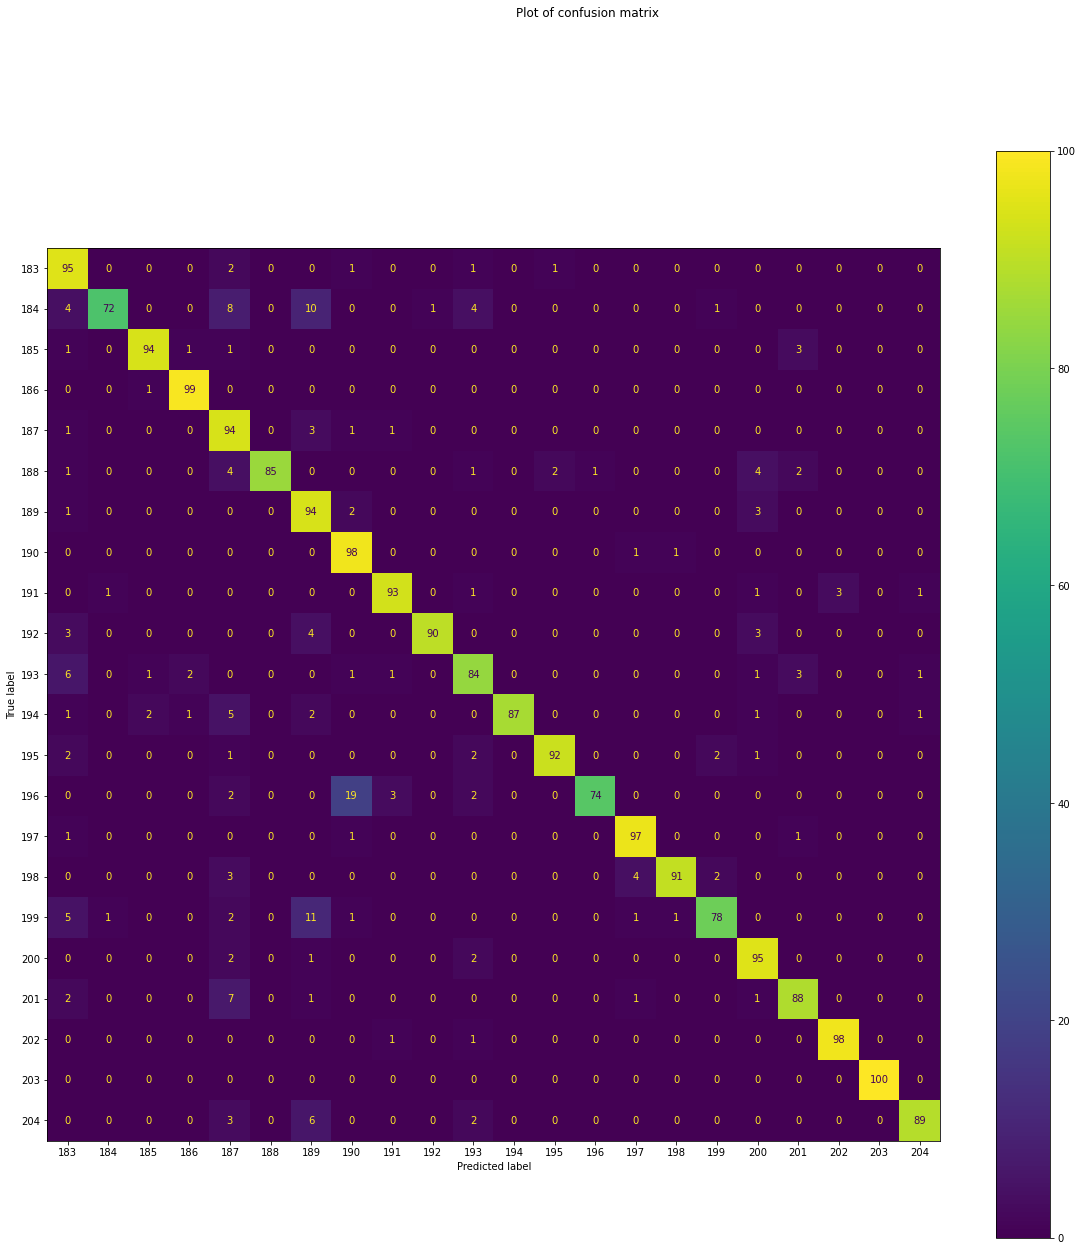

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display = ConfusionMatrixDisplay.from_predictions(all_classes, predicted_classes)
fig = display.figure_
fig.set_figwidth(20)
fig.set_figheight(20) 
fig.suptitle('Plot of confusion matrix')